In [2]:
#mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 3.4MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [4]:
!pip install tf_keras_vis

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May  7 19:17:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
#working_dir = pathlib.Path().absolute()
#os.chdir(working_dir)
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
import tables
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

In [0]:
import skimage
from skimage.transform import rotate
import random

In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

cell_type_idx_dict={0:'Actinic keratoses',1:'Basal cell carcinoma',
                    2:'Benign keratosis-like lesions',
                    3:'Dermatofibroma',4:'Melanocytic nevi',
                    5:'Melanoma',6:'Vascular lesions'    
}

In [0]:
meta_df_64_48=pd.read_hdf('/content/drive/My Drive/HAM10000/ham10000_64_48.h5')
meta_df_48_36=pd.read_hdf('/content/drive/My Drive/HAM10000/ham10000_48_36.h5')
meta_df_32_24=pd.read_hdf('/content/drive/My Drive/HAM10000/ham10000_32_24.h5')

In [0]:
np.random.seed(1234)
nevi_selected=np.random.choice(meta_df_32_24[meta_df_32_24.cell_type_idx==4].index,1117,replace=False)

In [0]:
meta_df_32_24_filtered=meta_df_32_24[meta_df_32_24.cell_type_idx != 4].append(meta_df_32_24.loc[nevi_selected])
meta_df_64_48_filtered=meta_df_64_48[meta_df_64_48.cell_type_idx != 4].append(meta_df_64_48.loc[nevi_selected])
meta_df_48_36_filtered=meta_df_48_36[meta_df_48_36.cell_type_idx != 4].append(meta_df_48_36.loc[nevi_selected])

In [0]:
def image_augmentation(row):
  row_new=row.copy()
  if np.random.random()<0.5:
    angle=np.random.uniform(-30,30)
  else:
    angle=np.random.uniform(150,210)
  row_new.image_rgb=skimage.transform.rotate(row.image_rgb,angle)
  row_new.image_gray=skimage.transform.rotate(row.image_gray,angle)
  return row_new

In [0]:
def df_augmentation(df):
  df_aug=df[1:1]
  for index, row in df.iterrows():
    if row.cell_type_idx in [4,5,2]:      
      row_new=image_augmentation(row)
      df_aug=df_aug.append(row_new)
    if row.cell_type_idx==1:
      for i in range(2):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
    if row.cell_type_idx==0:
      for i in range(3):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
    if row.cell_type_idx==6:
      for i in range(7):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
    if row.cell_type_idx==3:
      for i in range(8):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
  return df_aug



In [0]:
np.random.seed(3333)
meta_df_32_24_aug=df_augmentation(meta_df_32_24_filtered)


In [0]:
np.random.seed(3333)
meta_df_48_36_aug=df_augmentation(meta_df_48_36_filtered)


In [0]:
np.random.seed(3333)
meta_df_64_48_aug=df_augmentation(meta_df_64_48_filtered)


In [0]:
rgb_df_64_48=meta_df_64_48_aug.drop(columns=['image_gray'])
gray_df_64_48=meta_df_64_48_aug.drop(columns=['image_rgb'])

rgb_df_48_36=meta_df_48_36_aug.drop(columns=['image_gray'])
gray_df_48_36=meta_df_48_36_aug.drop(columns=['image_rgb'])

rgb_df_32_24=meta_df_32_24_aug.drop(columns=['image_gray'])
gray_df_32_24=meta_df_32_24_aug.drop(columns=['image_rgb'])

Augmented dataset

In [0]:
rgb_train_df_64_48,rgb_test_df_64_48=train_test_split(rgb_df_64_48,test_size=0.2,random_state=6862,stratify=rgb_df_64_48.cell_type_idx)
rgb_train_df_64_48,rgb_validation_df_64_48=train_test_split(rgb_train_df_64_48,test_size=0.25,random_state=6036,stratify=rgb_train_df_64_48.cell_type_idx)

gray_train_df_64_48,gray_test_df_64_48=train_test_split(gray_df_64_48,test_size=0.2,random_state=6862,stratify=gray_df_64_48.cell_type_idx)
gray_train_df_64_48,gray_validation_df_64_48=train_test_split(gray_train_df_64_48,test_size=0.25,random_state=6036,stratify=gray_train_df_64_48.cell_type_idx)

rgb_train_df_48_36,rgb_test_df_48_36=train_test_split(rgb_df_48_36,test_size=0.2,random_state=6862,stratify=rgb_df_48_36.cell_type_idx)
rgb_train_df_48_36,rgb_validation_df_48_36=train_test_split(rgb_train_df_48_36,test_size=0.25,random_state=6036,stratify=rgb_train_df_48_36.cell_type_idx)

gray_train_df_48_36,gray_test_df_48_36=train_test_split(gray_df_48_36,test_size=0.2,random_state=6862,stratify=gray_df_48_36.cell_type_idx)
gray_train_df_48_36,gray_validation_df_48_36=train_test_split(gray_train_df_48_36,test_size=0.25,random_state=6036,stratify=gray_train_df_48_36.cell_type_idx)

rgb_train_df_32_24,rgb_test_df_32_24=train_test_split(rgb_df_32_24,test_size=0.2,random_state=6862,stratify=rgb_df_32_24.cell_type_idx)
rgb_train_df_32_24,rgb_validation_df_32_24=train_test_split(rgb_train_df_32_24,test_size=0.25,random_state=6036,stratify=rgb_train_df_32_24.cell_type_idx)

gray_train_df_32_24,gray_test_df_32_24=train_test_split(gray_df_32_24,test_size=0.2,random_state=6862,stratify=gray_df_32_24.cell_type_idx)
gray_train_df_32_24,gray_validation_df_32_24=train_test_split(gray_train_df_32_24,test_size=0.25,random_state=6036,stratify=gray_train_df_32_24.cell_type_idx)

In [0]:
rgb_x_train_64_48=np.asarray(rgb_train_df_64_48.image_rgb.tolist())
rgb_y_train_64_48=np.asarray(rgb_train_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_validation_64_48=np.asarray(rgb_validation_df_64_48.image_rgb.tolist())
rgb_y_validation_64_48=np.asarray(rgb_validation_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_test_64_48=np.asarray(rgb_test_df_64_48.image_rgb.tolist())
rgb_y_test_64_48=np.asarray(rgb_test_df_64_48.cell_type_idx.tolist()).reshape(-1,1)

rgb_x_train_48_36=np.asarray(rgb_train_df_48_36.image_rgb.tolist())
rgb_y_train_48_36=np.asarray(rgb_train_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_validation_48_36=np.asarray(rgb_validation_df_48_36.image_rgb.tolist())
rgb_y_validation_48_36=np.asarray(rgb_validation_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_test_48_36=np.asarray(rgb_test_df_48_36.image_rgb.tolist())
rgb_y_test_48_36=np.asarray(rgb_test_df_48_36.cell_type_idx.tolist()).reshape(-1,1)

rgb_x_train_32_24=np.asarray(rgb_train_df_32_24.image_rgb.tolist())
rgb_y_train_32_24=np.asarray(rgb_train_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_validation_32_24=np.asarray(rgb_validation_df_32_24.image_rgb.tolist())
rgb_y_validation_32_24=np.asarray(rgb_validation_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_test_32_24=np.asarray(rgb_test_df_32_24.image_rgb.tolist())
rgb_y_test_32_24=np.asarray(rgb_test_df_32_24.cell_type_idx.tolist()).reshape(-1,1)

In [0]:
gray_x_train_64_48=np.asarray(gray_train_df_64_48.image_gray.tolist())
gray_x_train_64_48=np.expand_dims(gray_x_train_64_48,axis=3)
gray_y_train_64_48=np.asarray(gray_train_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
gray_x_validation_64_48=np.asarray(gray_validation_df_64_48.image_gray.tolist())
gray_x_validation_64_48=np.expand_dims(gray_x_validation_64_48,axis=3)
gray_y_validation_64_48=np.asarray(gray_validation_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
gray_x_test_64_48=np.asarray(gray_test_df_64_48.image_gray.tolist())
gray_x_test_64_48=np.expand_dims(gray_x_test_64_48,axis=3)
gray_y_test_64_48=np.asarray(gray_test_df_64_48.cell_type_idx.tolist()).reshape(-1,1)

gray_x_train_48_36=np.asarray(gray_train_df_48_36.image_gray.tolist())
gray_x_train_48_36=np.expand_dims(gray_x_train_48_36,axis=3)
gray_y_train_48_36=np.asarray(gray_train_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
gray_x_validation_48_36=np.asarray(gray_validation_df_48_36.image_gray.tolist())
gray_x_validation_48_36=np.expand_dims(gray_x_validation_48_36,axis=3)
gray_y_validation_48_36=np.asarray(gray_validation_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
gray_x_test_48_36=np.asarray(gray_test_df_48_36.image_gray.tolist())
gray_x_test_48_36=np.expand_dims(gray_x_test_48_36,axis=3)
gray_y_test_48_36=np.asarray(gray_test_df_48_36.cell_type_idx.tolist()).reshape(-1,1)

gray_x_train_32_24=np.asarray(gray_train_df_32_24.image_gray.tolist())
gray_x_train_32_24=np.expand_dims(gray_x_train_32_24,axis=3)
gray_y_train_32_24=np.asarray(gray_train_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
gray_x_validation_32_24=np.asarray(gray_validation_df_32_24.image_gray.tolist())
gray_x_validation_32_24=np.expand_dims(gray_x_validation_32_24,axis=3)
gray_y_validation_32_24=np.asarray(gray_validation_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
gray_x_test_32_24=np.asarray(gray_test_df_32_24.image_gray.tolist())
gray_x_test_32_24=np.expand_dims(gray_x_test_32_24,axis=3)
gray_y_test_32_24=np.asarray(gray_test_df_32_24.cell_type_idx.tolist()).reshape(-1,1)

In [0]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',
                          cmap=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    

In [0]:
def plot_roc(model,x,y,title='ROC'):
  import sklearn.metrics as metrics
  fpr0, tpr0, threshold=metrics.roc_curve(y==0,model.predict(x)[:,0])
  roc_auc0=metrics.auc(fpr0,tpr0)

  fpr1, tpr1, threshold=metrics.roc_curve(y==1,model.predict(x)[:,1])
  roc_auc1=metrics.auc(fpr1,tpr1)

  fpr2, tpr2, threshold=metrics.roc_curve(y==2,model.predict(x)[:,2])
  roc_auc2=metrics.auc(fpr2,tpr2)

  fpr3, tpr3, threshold=metrics.roc_curve(y==3,model.predict(x)[:,3])
  roc_auc3=metrics.auc(fpr3,tpr3)

  fpr4, tpr4, threshold=metrics.roc_curve(y==4,model.predict(x)[:,4])
  roc_auc4=metrics.auc(fpr4,tpr4)

  fpr5, tpr5, threshold=metrics.roc_curve(y==5,model.predict(x)[:,5])
  roc_auc5=metrics.auc(fpr5,tpr5)

  fpr6, tpr6, threshold=metrics.roc_curve(y==6,model.predict(x)[:,6])
  roc_auc6=metrics.auc(fpr6,tpr6)

  plt.plot(fpr0, tpr0, label = f'{cell_type_idx_dict[0]}, auc = {round(roc_auc0,3)}')
  plt.plot(fpr1, tpr1, label = f'{cell_type_idx_dict[1]}, auc = {round(roc_auc1,3)}')
  plt.plot(fpr2, tpr2, label = f'{cell_type_idx_dict[2]}, auc = {round(roc_auc2,3)}')
  plt.plot(fpr3, tpr3, label = f'{cell_type_idx_dict[3]}, auc = {round(roc_auc3,3)}')
  plt.plot(fpr4, tpr4, label = f'{cell_type_idx_dict[4]}, auc = {round(roc_auc4,3)}')
  plt.plot(fpr5, tpr5, label = f'{cell_type_idx_dict[5]}, auc = {round(roc_auc5,3)}')
  plt.plot(fpr6, tpr6, label = f'{cell_type_idx_dict[6]}, auc = {round(roc_auc6,3)}')
  plt.title(title)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend()

In [0]:
def plot_history(h,title='History'):
  fig, ax = plt.subplots(1,2,figsize = (15,5))
  
  ax[0].plot(h.history['accuracy'], label = "Training data")
  ax[0].plot(h.history['val_accuracy'], label = "Validation data")
  ax[0].set_xlabel("epoch")
  ax[0].set_ylabel("accuracy")
  ax[0].set_title(title+" Accuracy")
  ax[0].legend()

  ax[1].plot(h.history['loss'], label = "Training data")
  ax[1].plot(h.history['val_loss'], label = "Validation data")
  ax[1].set_xlabel("epoch")
  ax[1].set_ylabel("loss")
  ax[1].set_title(title+" Loss")
  ax[1].legend()

  plt.show()

In [25]:
rgb_64_48_model = Sequential()
rgb_64_48_model.add(Conv2D(input_shape=(48,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_64_48_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_64_48_model.add(BatchNormalization())
rgb_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_64_48_model.add(BatchNormalization())
rgb_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_64_48_model.add(BatchNormalization())
rgb_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_64_48_model.add(Flatten())
rgb_64_48_model.add(Dense(units=128,activation="relu"))
rgb_64_48_model.add(Dense(units=64,activation="relu"))
rgb_64_48_model.add(Dense(units=7, activation="softmax"))
rgb_64_48_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 32, 128)       5

In [0]:
gray_64_48_model = Sequential()
gray_64_48_model.add(Conv2D(input_shape=(48,64,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_64_48_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_64_48_model.add(BatchNormalization())
gray_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(BatchNormalization())
gray_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(BatchNormalization())
gray_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_64_48_model.add(Flatten())
gray_64_48_model.add(Dense(units=128,activation="relu"))
gray_64_48_model.add(Dense(units=64,activation="relu"))
gray_64_48_model.add(Dense(units=7, activation="softmax"))

In [0]:
rgb_48_36_model = Sequential()
rgb_48_36_model.add(Conv2D(input_shape=(36,48,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_48_36_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_48_36_model.add(BatchNormalization())
rgb_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_48_36_model.add(BatchNormalization())
rgb_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_48_36_model.add(BatchNormalization())
rgb_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_48_36_model.add(Flatten())
rgb_48_36_model.add(Dense(units=128,activation="relu"))
rgb_48_36_model.add(Dense(units=64,activation="relu"))
rgb_48_36_model.add(Dense(units=7, activation="softmax"))

rgb_32_24_model = Sequential()
rgb_32_24_model.add(Conv2D(input_shape=(24,32,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_32_24_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_32_24_model.add(BatchNormalization())
rgb_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(BatchNormalization())
rgb_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(BatchNormalization())
rgb_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_32_24_model.add(Flatten())
rgb_32_24_model.add(Dense(units=128,activation="relu"))
rgb_32_24_model.add(Dense(units=64,activation="relu"))
rgb_32_24_model.add(Dense(units=7, activation="softmax"))

gray_48_36_model = Sequential()
gray_48_36_model.add(Conv2D(input_shape=(36,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_48_36_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_48_36_model.add(BatchNormalization())
gray_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(BatchNormalization())
gray_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(BatchNormalization())
gray_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_48_36_model.add(Flatten())
gray_48_36_model.add(Dense(units=128,activation="relu"))
gray_48_36_model.add(Dense(units=64,activation="relu"))
gray_48_36_model.add(Dense(units=7, activation="softmax"))

gray_32_24_model = Sequential()
gray_32_24_model.add(Conv2D(input_shape=(24,32,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_32_24_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_32_24_model.add(BatchNormalization())
gray_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(BatchNormalization())
gray_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(BatchNormalization())
gray_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_32_24_model.add(Flatten())
gray_32_24_model.add(Dense(units=128,activation="relu"))
gray_32_24_model.add(Dense(units=64,activation="relu"))
gray_32_24_model.add(Dense(units=7, activation="softmax"))

In [28]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
rgb_64_48_model.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_rgb_64_48 = rgb_64_48_model.fit(np.array(rgb_x_train_64_48), np.array(rgb_y_train_64_48), epochs = 100, batch_size = 32, validation_data = (np.array(rgb_x_validation_64_48),np.array(rgb_y_validation_64_48)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 2s 16ms/step - loss: 1.6168 - accuracy: 0.3743 - val_loss: 2.7654 - val_accuracy: 0.1516
Epoch 2/100
136/136 [==============================] - 2s 13ms/step - loss: 1.2023 - accuracy: 0.5462 - val_loss: 2.8486 - val_accuracy: 0.1516
Epoch 3/100
136/136 [==============================] - 2s 13ms/step - loss: 0.9732 - accuracy: 0.6301 - val_loss: 2.1190 - val_accuracy: 0.2281
Epoch 4/100
136/136 [==============================] - 2s 13ms/step - loss: 0.8256 - accuracy: 0.6982 - val_loss: 1.5906 - val_accuracy: 0.4039
Epoch 5/100
136/136 [==============================] - 2s 13ms/step - loss: 0.6993 - accuracy: 0.7453 - val_loss: 1.1456 - val_accuracy: 0.5610
Epoch 6/100
136/136 [==============================] - 2s 13ms/step - loss: 0.5671 - accuracy: 0.7972 - val_loss: 1.1829 - val_accuracy: 0.5541
Epoch 7/100
136/136 [==============================] - 2s 13ms/step - loss: 0.4381 - accuracy: 0.8531 - val_loss: 1.1827 - val_accuracy:

KeyboardInterrupt: ignored

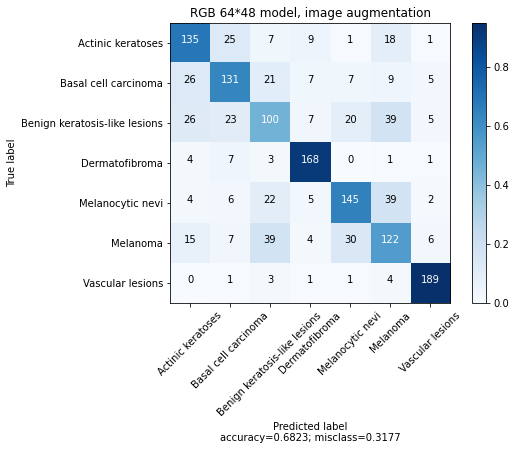

In [33]:
rgb_64_48_model.load_weights('rgb_64_48_aug.h5')
cm_rgb_64_48=confusion_matrix(rgb_y_test_64_48, np.argmax(rgb_64_48_model.predict(rgb_x_test_64_48),axis=1))
plot_confusion_matrix(cm_rgb_64_48,sorted(cell_type_idx_dict.values()),'RGB 64*48 model, image augmentation')

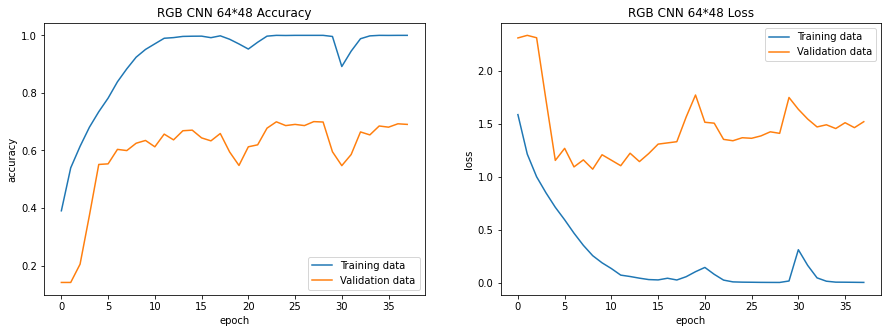

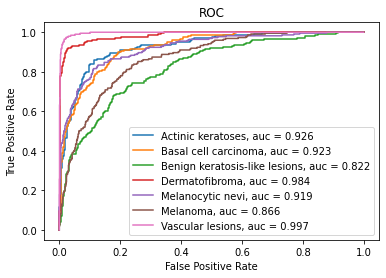

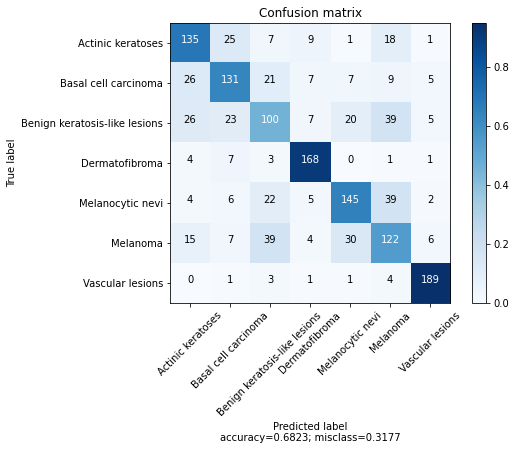

In [0]:
plot_history(h_rgb_64_48,'RGB CNN 64*48')
plot_roc(rgb_64_48_model,rgb_x_test_64_48,rgb_y_test_64_48)
cm_rgb_64_48=confusion_matrix(rgb_y_test_64_48, np.argmax(rgb_64_48_model.predict(rgb_x_test_64_48),axis=1))
plot_confusion_matrix(cm_rgb_64_48,sorted(cell_type_idx_dict.values()))


In [0]:
rgb_64_48_model.save('rgb_64_48_aug.h5')

In [0]:
rgb_64_48_model.load_weights('rgb_64_48.h5')

In [0]:
gray_64_48_model = Sequential()
gray_64_48_model.add(Conv2D(input_shape=(48,64,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_64_48_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_64_48_model.add(BatchNormalization())
gray_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(BatchNormalization())
gray_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_64_48_model.add(BatchNormalization())
gray_64_48_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_64_48_model.add(Flatten())
gray_64_48_model.add(Dense(units=128,activation="relu"))
gray_64_48_model.add(Dense(units=64,activation="relu"))
gray_64_48_model.add(Dense(units=7, activation="softmax"))

In [0]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
gray_64_48_model.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 15,
    verbose = 1)
    #checkpoint
]
h_gray_64_48 = gray_64_48_model.fit(np.array(gray_x_train_64_48), np.array(gray_y_train_64_48), epochs = 100, batch_size = 32, validation_data = (np.array(gray_x_validation_64_48),np.array(gray_y_validation_64_48)), callbacks = callbacks)



Epoch 1/100
136/136 [==============================] - 2s 14ms/step - loss: 1.8052 - accuracy: 0.2828 - val_loss: 2.0120 - val_accuracy: 0.1371
Epoch 2/100
136/136 [==============================] - 2s 13ms/step - loss: 1.5440 - accuracy: 0.3885 - val_loss: 2.2816 - val_accuracy: 0.1371
Epoch 3/100
136/136 [==============================] - 2s 13ms/step - loss: 1.4380 - accuracy: 0.4425 - val_loss: 2.6009 - val_accuracy: 0.1378
Epoch 4/100
136/136 [==============================] - 2s 13ms/step - loss: 1.3402 - accuracy: 0.4823 - val_loss: 2.1352 - val_accuracy: 0.2212
Epoch 5/100
136/136 [==============================] - 2s 13ms/step - loss: 1.2200 - accuracy: 0.5343 - val_loss: 1.6447 - val_accuracy: 0.3446
Epoch 6/100
136/136 [==============================] - 2s 13ms/step - loss: 1.1029 - accuracy: 0.5901 - val_loss: 1.6029 - val_accuracy: 0.3770
Epoch 7/100
136/136 [==============================] - 2s 13ms/step - loss: 0.9499 - accuracy: 0.6437 - val_loss: 1.8129 - val_accuracy:

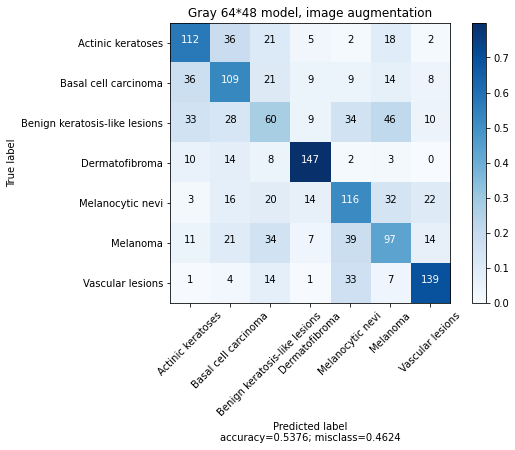

In [32]:
gray_64_48_model.load_weights('gray_64_48_aug.h5')
cm_gray_64_48=confusion_matrix(gray_y_test_64_48, np.argmax(gray_64_48_model.predict(gray_x_test_64_48),axis=1))
plot_confusion_matrix(cm_gray_64_48,sorted(cell_type_idx_dict.values()),'Gray 64*48 model, image augmentation')

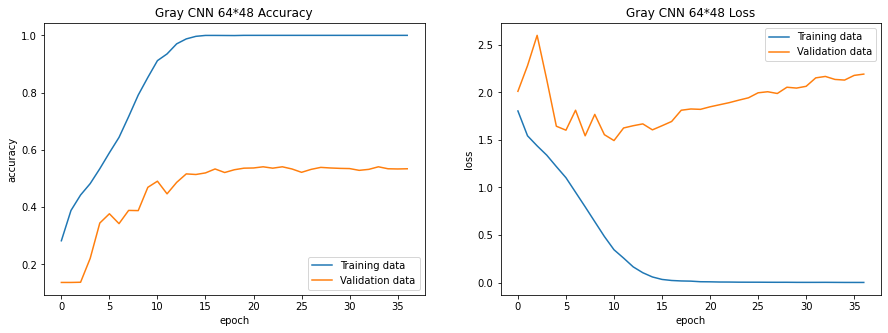

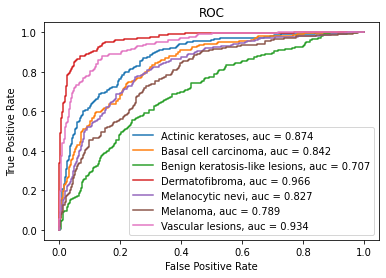

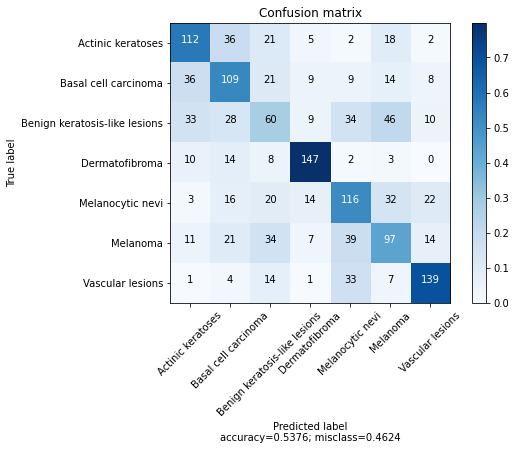

In [0]:
plot_history(h_gray_64_48,'Gray CNN 64*48')
plot_roc(gray_64_48_model,gray_x_test_64_48,gray_y_test_64_48)
cm_gray_64_48=confusion_matrix(gray_y_test_64_48, np.argmax(gray_64_48_model.predict(gray_x_test_64_48),axis=1))
plot_confusion_matrix(cm_gray_64_48,sorted(cell_type_idx_dict.values()))

In [0]:
gray_64_48_model.save('gray_64_48_aug.h5')

In [0]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
rgb_48_36_model.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_rgb_48_36 = rgb_48_36_model.fit(np.array(rgb_x_train_48_36), np.array(rgb_y_train_48_36), epochs = 100, batch_size = 32, validation_data = (np.array(rgb_x_validation_48_36),np.array(rgb_y_validation_48_36)), callbacks = callbacks)


Epoch 1/100
136/136 [==============================] - 2s 12ms/step - loss: 1.5659 - accuracy: 0.4011 - val_loss: 2.2175 - val_accuracy: 0.1351
Epoch 2/100
136/136 [==============================] - 1s 10ms/step - loss: 1.1903 - accuracy: 0.5501 - val_loss: 2.4698 - val_accuracy: 0.1351
Epoch 3/100
136/136 [==============================] - 1s 10ms/step - loss: 1.0304 - accuracy: 0.6122 - val_loss: 2.1255 - val_accuracy: 0.1895
Epoch 4/100
136/136 [==============================] - 1s 10ms/step - loss: 0.8648 - accuracy: 0.6807 - val_loss: 1.5102 - val_accuracy: 0.4156
Epoch 5/100
136/136 [==============================] - 1s 10ms/step - loss: 0.7411 - accuracy: 0.7257 - val_loss: 1.1622 - val_accuracy: 0.5513
Epoch 6/100
136/136 [==============================] - 1s 10ms/step - loss: 0.6299 - accuracy: 0.7766 - val_loss: 1.3397 - val_accuracy: 0.5300
Epoch 7/100
136/136 [==============================] - 1s 10ms/step - loss: 0.5173 - accuracy: 0.8168 - val_loss: 1.0259 - val_accuracy:

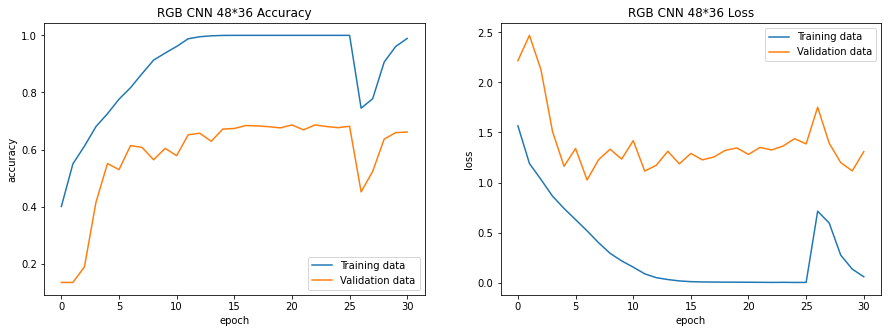

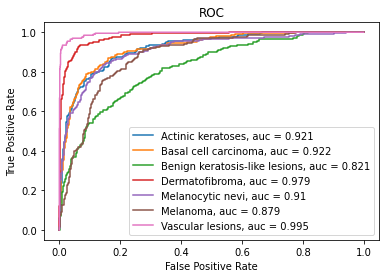

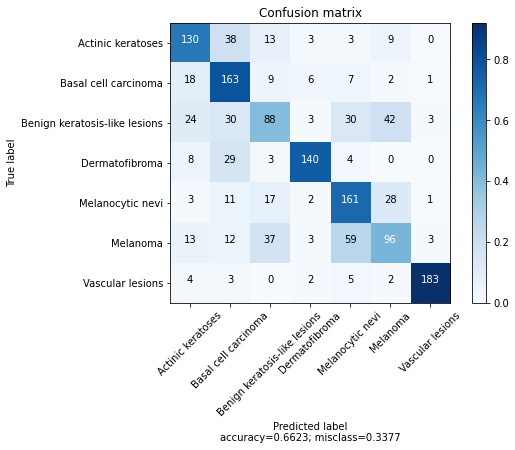

In [0]:
plot_history(h_rgb_48_36,'RGB CNN 48*36')
plot_roc(rgb_48_36_model,rgb_x_test_48_36,rgb_y_test_48_36)
cm_rgb_48_36=confusion_matrix(rgb_y_test_48_36, np.argmax(rgb_48_36_model.predict(rgb_x_test_48_36),axis=1))
plot_confusion_matrix(cm_rgb_48_36,sorted(cell_type_idx_dict.values()))

In [0]:
rgb_48_36_model.save('rgb_48_36_aug.h5')

In [0]:
gray_48_36_model = Sequential()
gray_48_36_model.add(Conv2D(input_shape=(36,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_48_36_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_48_36_model.add(BatchNormalization())
gray_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(BatchNormalization())
gray_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_48_36_model.add(BatchNormalization())
gray_48_36_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_48_36_model.add(Flatten())
gray_48_36_model.add(Dense(units=128,activation="relu"))
gray_48_36_model.add(Dense(units=64,activation="relu"))
gray_48_36_model.add(Dense(units=7, activation="softmax"))

In [0]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
gray_48_36_model.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 15,
    verbose = 1)
    #checkpoint
]
h_gray_48_36 = gray_48_36_model.fit(np.array(gray_x_train_48_36), np.array(gray_y_train_48_36), epochs = 100, batch_size = 32, validation_data = (np.array(gray_x_validation_48_36),np.array(gray_y_validation_48_36)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 1s 10ms/step - loss: 1.7942 - accuracy: 0.2908 - val_loss: 2.2326 - val_accuracy: 0.1351
Epoch 2/100
136/136 [==============================] - 1s 9ms/step - loss: 1.5622 - accuracy: 0.3786 - val_loss: 2.4870 - val_accuracy: 0.1144
Epoch 3/100
136/136 [==============================] - 1s 9ms/step - loss: 1.4607 - accuracy: 0.4310 - val_loss: 2.3732 - val_accuracy: 0.1337
Epoch 4/100
136/136 [==============================] - 1s 9ms/step - loss: 1.3267 - accuracy: 0.4860 - val_loss: 1.8275 - val_accuracy: 0.2598
Epoch 5/100
136/136 [==============================] - 1s 9ms/step - loss: 1.2175 - accuracy: 0.5377 - val_loss: 1.5971 - val_accuracy: 0.3715
Epoch 6/100
136/136 [==============================] - 1s 9ms/step - loss: 1.1024 - accuracy: 0.5834 - val_loss: 1.5401 - val_accuracy: 0.3756
Epoch 7/100
136/136 [==============================] - 1s 9ms/step - loss: 0.9926 - accuracy: 0.6343 - val_loss: 1.6302 - val_accuracy: 0.401

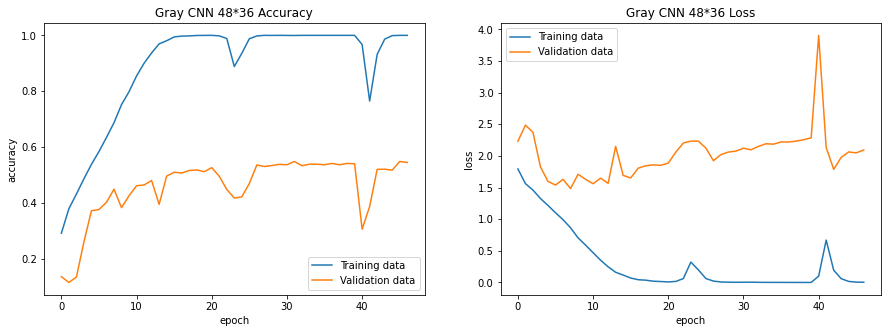

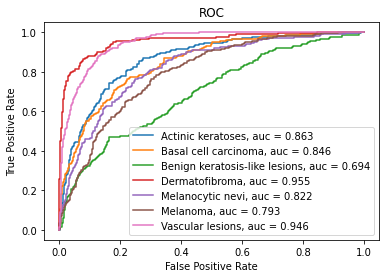

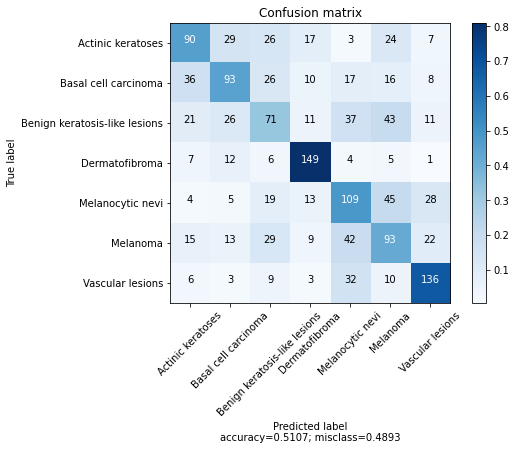

In [0]:
plot_history(h_gray_48_36,'Gray CNN 48*36')
plot_roc(gray_48_36_model,gray_x_test_48_36,gray_y_test_48_36)
cm_gray_48_36=confusion_matrix(gray_y_test_48_36, np.argmax(gray_48_36_model.predict(gray_x_test_48_36),axis=1))
plot_confusion_matrix(cm_gray_48_36,sorted(cell_type_idx_dict.values()))

In [0]:
gray_48_36_model.save('gray_48_36_aug.h5')

In [0]:
rgb_32_24_model = Sequential()
rgb_32_24_model.add(Conv2D(input_shape=(24,32,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_32_24_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
rgb_32_24_model.add(BatchNormalization())
rgb_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(BatchNormalization())
rgb_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
rgb_32_24_model.add(BatchNormalization())
rgb_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
rgb_32_24_model.add(Flatten())
rgb_32_24_model.add(Dense(units=128,activation="relu"))
rgb_32_24_model.add(Dense(units=64,activation="relu"))
rgb_32_24_model.add(Dense(units=7, activation="softmax"))

In [0]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
rgb_32_24_model.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_rgb_32_24 = rgb_32_24_model.fit(np.array(rgb_x_train_32_24), np.array(rgb_y_train_32_24), epochs = 100, batch_size = 32, validation_data = (np.array(rgb_x_validation_32_24),np.array(rgb_y_validation_32_24)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 1s 7ms/step - loss: 1.6103 - accuracy: 0.3876 - val_loss: 2.0118 - val_accuracy: 0.1358
Epoch 2/100
136/136 [==============================] - 1s 6ms/step - loss: 1.2198 - accuracy: 0.5354 - val_loss: 2.0161 - val_accuracy: 0.1440
Epoch 3/100
136/136 [==============================] - 1s 6ms/step - loss: 1.0097 - accuracy: 0.6246 - val_loss: 1.8800 - val_accuracy: 0.1819
Epoch 4/100
136/136 [==============================] - 1s 6ms/step - loss: 0.8653 - accuracy: 0.6834 - val_loss: 1.4978 - val_accuracy: 0.4445
Epoch 5/100
136/136 [==============================] - 1s 6ms/step - loss: 0.7511 - accuracy: 0.7260 - val_loss: 1.1320 - val_accuracy: 0.5762
Epoch 6/100
136/136 [==============================] - 1s 6ms/step - loss: 0.6240 - accuracy: 0.7729 - val_loss: 1.2488 - val_accuracy: 0.5410
Epoch 7/100
136/136 [==============================] - 1s 6ms/step - loss: 0.5078 - accuracy: 0.8257 - val_loss: 1.3358 - val_accuracy: 0.5258

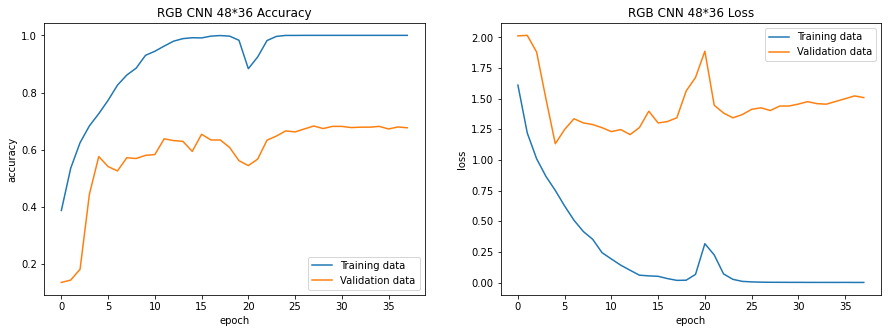

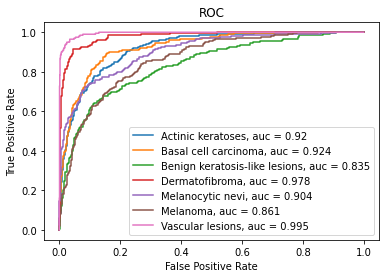

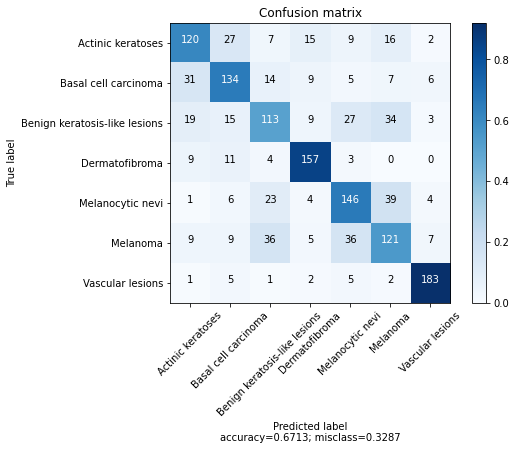

In [0]:
plot_history(h_rgb_32_24,'RGB CNN 48*36')
plot_roc(rgb_32_24_model,rgb_x_test_32_24,rgb_y_test_32_24)
cm_rgb_32_24=confusion_matrix(rgb_y_test_32_24, np.argmax(rgb_32_24_model.predict(rgb_x_test_32_24),axis=1))
plot_confusion_matrix(cm_rgb_32_24,sorted(cell_type_idx_dict.values()))

In [0]:
rgb_32_24_model.save('rgb_32_24_aug.h5')

In [0]:
gray_32_24_model = Sequential()
gray_32_24_model.add(Conv2D(input_shape=(24,32,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_32_24_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
gray_32_24_model.add(BatchNormalization())
gray_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(BatchNormalization())
gray_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
gray_32_24_model.add(BatchNormalization())
gray_32_24_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
gray_32_24_model.add(Flatten())
gray_32_24_model.add(Dense(units=128,activation="relu"))
gray_32_24_model.add(Dense(units=64,activation="relu"))
gray_32_24_model.add(Dense(units=7, activation="softmax"))

In [0]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
gray_32_24_model.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_gray_32_24 = gray_32_24_model.fit(np.array(gray_x_train_32_24), np.array(gray_y_train_32_24), epochs = 100, batch_size = 32, validation_data = (np.array(gray_x_validation_32_24),np.array(gray_y_validation_32_24)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 1s 7ms/step - loss: 1.7741 - accuracy: 0.2899 - val_loss: 2.0460 - val_accuracy: 0.1268
Epoch 2/100
136/136 [==============================] - 1s 6ms/step - loss: 1.5393 - accuracy: 0.3910 - val_loss: 2.2018 - val_accuracy: 0.1489
Epoch 3/100
136/136 [==============================] - 1s 6ms/step - loss: 1.4580 - accuracy: 0.4324 - val_loss: 2.1488 - val_accuracy: 0.1530
Epoch 4/100
136/136 [==============================] - 1s 6ms/step - loss: 1.3293 - accuracy: 0.4956 - val_loss: 2.1569 - val_accuracy: 0.1826
Epoch 5/100
136/136 [==============================] - 1s 6ms/step - loss: 1.2530 - accuracy: 0.5299 - val_loss: 1.6168 - val_accuracy: 0.3666
Epoch 6/100
136/136 [==============================] - 1s 6ms/step - loss: 1.1174 - accuracy: 0.5825 - val_loss: 1.5858 - val_accuracy: 0.3928
Epoch 7/100
136/136 [==============================] - 1s 6ms/step - loss: 1.0118 - accuracy: 0.6264 - val_loss: 2.0222 - val_accuracy: 0.3136

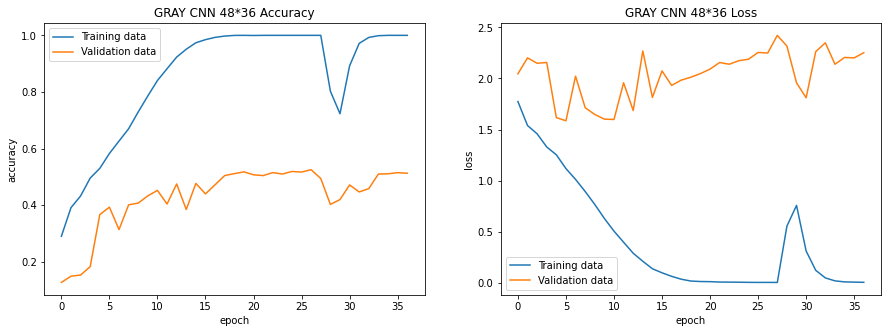

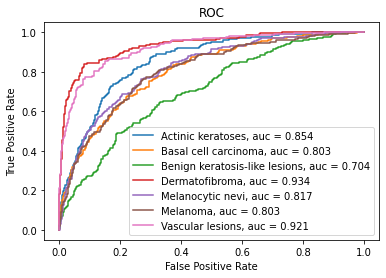

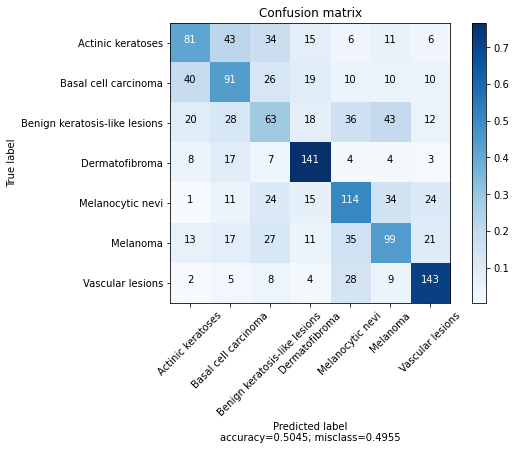

In [0]:
plot_history(h_gray_32_24,'GRAY CNN 48*36')
plot_roc(gray_32_24_model,gray_x_test_32_24,gray_y_test_32_24)
cm_gray_32_24=confusion_matrix(gray_y_test_32_24, np.argmax(gray_32_24_model.predict(gray_x_test_32_24),axis=1))
plot_confusion_matrix(cm_gray_32_24,sorted(cell_type_idx_dict.values()))

In [0]:
gray_32_24_model.save('gray_32_24_aug.h5')